More PyTorch tutorials can be found at [https://pytorch.org/tutorials/](https://pytorch.org/tutorials/)

# Import pytorch libraries

In [5]:
#!module load pytorch
#!pip3 install torch torchvision

In [1]:
import math
import numpy as np

import torch
from torch import nn, optim, cuda
from torch.autograd import Variable
from torch.utils.data import DataLoader

import torchvision
from torchvision import datasets, transforms

import torch.nn.functional as F

use_gpu=False

if cuda.is_available():
    # check if GPU is available
    print(cuda.get_device_properties(0))

# for visualization
import matplotlib.pyplot as plt
%matplotlib inline

# Steps to create a Neural Networks with Pytorch

1. Define dataset, data loader and transformations
1. Define a Neural Network (forward propagation)
1. Define optimizer and criterion
1. Train the model (back propagation)
1. Evaluate the model
1. Make prediction

# Step 1: Define dataset, data loader and transformation

<!-- PyTorch gives use the freedom to pretty much do anything with the Dataset class so long as you override two of the subclass functions:
* the __len__ function which returns the size of the dataset, and
* the __getitem__ function which returns a sample from the dataset given an index.

However, in our case we can simply construct a TensorDataset with two items: the feature data and the target where the feature data is the matrix of pixel 1 - pixel 784 and the target is the digit of the image. -->


While the Dataset class is a nice way of containing data systematically, it seems that in a training loop, we will need to index or slice the dataset's samples list. This is no better than what we would do for a typical list or NumPy matrix. Rather than going down that route, PyTorch supplies another utility function called the DataLoader which acts as a data feeder for a Dataset object.


In order to construct the data loader we will need to provide two parameters: **batch_size** which indicates how many samples we want to use to train  the model in a batch, and **shuflle**, suggesting if we want to shuffle the data before sending it to the network. 

Typically we would want to set batch_size as $2^n$ e.g. 128, 256, 512, and set `shuffle` as `True` for traning data and `False` for validation and test data (you can take a moment to think why?)



### Download Datasets

In [2]:
# preparing transforming functions
data_tf=transforms.Compose([transforms.ToTensor(), transforms.Normalize([0.5],[0.5])])

# download datasets
train_dataset = datasets.MNIST(root='../data', train=True, transform=data_tf, download=True)
test_dataset = datasets.MNIST(root='../data', train=False, transform=data_tf, download=True)


### Load Datasets

In [3]:
# data loader
batch_size=64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

## Display sample pictures from the dataset

<!-- row_num=8 # if batch_size=64, plot matrix as 8x8
column_num=int(batch_size/row_num)

#---create a grid figure----
fig, axes = plt.subplots(row_num, column_num, figsize=(8, 8),
                         subplot_kw={'xticks':[], 'yticks':[]},
                         gridspec_kw=dict(hspace=0.1, wspace=0.1))

#---iterate and plot figures---
for i, ax in enumerate(axes.flat):
    ax.imshow(test_dataset.data[i], cmap='Greys', interpolation='nearest')
    ax.text(0.1, 0.1, test_dataset.targets[i].numpy(), transform=ax.transAxes, color='green')
 -->


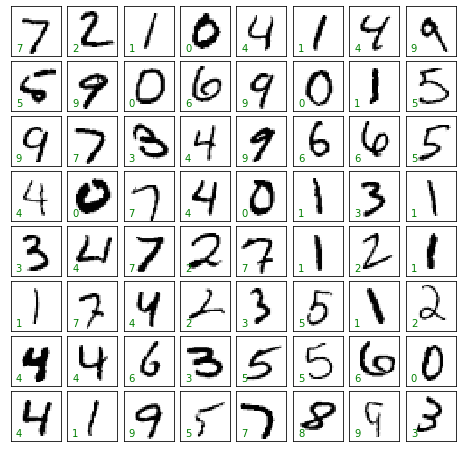

In [4]:
sample_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
data=iter(sample_loader)
samples,sample_labels=next(data)

row_num=8 # if batch_size=64, plot matrix as 8x8
column_num=int(batch_size/row_num)


fig, axes = plt.subplots(row_num, column_num, figsize=(8, 8),
                         subplot_kw={'xticks':[], 'yticks':[]},
                         gridspec_kw=dict(hspace=0.1, wspace=0.1))

for i, ax in enumerate(axes.flat):
    ax.imshow(samples[i][0], cmap='Greys', interpolation='nearest')
    ax.text(0.1, 0.1, sample_labels[i].numpy(), transform=ax.transAxes, color='green')

# Step 2: Define a Neural Networks

![nn](images/neural_network_example.png)

The neural network architectures in Pytorch can be defined in a class which inherits the properties from the base class from **nn** package called Module. This inheritance from the nn.Module class allows us to implement, access, and call a number of methods easily. We can define all the layers inside the constructor of the class, and the forward propagation steps inside the forward function.

We will define a simple Multilayer Perceptron with the following architecture:

* Input layer
```Python
nn.Linear(28 * 28, 512)
```
    * Layer type: nn.Linear(), which refers to a fully connection layer
    * Input size: 28*28, corresponding to the size of input data.
    * Output size: 512, the number of "neurons".
    
* Hidden layer
```
nn.Linear(512, 256)
```

    * Layer type: nn.Linear()
    * Input size: 512, output size of the previous layer(input layer).
    * Output size: 256, the number of "neurons" in this layer.
    
* Output layer
```
nn.Linear(256, 10)
```

    * Layer type: nn.Linear()
    * Input size: 256, output size of the previous layer(hidden layer).
    * Output size: 10, the number of classes we need to predict.

* Activation functions
Each linear layer's output needs to go through an activation function to "activate" it. We will get started with **F.sigmoid()** but can try F.relu() or others later.

The best practice is to name each layer and initialize them in the **__init__()** function as named building blocks and put the building blocks together in the **forward()** function which defines how the data actually flows in the network. In our case, each layer simply takes the output of the previous layer and perform transformations the generate outputs in sequence.

In [5]:
class simpleNet(nn.Module):
    """
    A simple 3-layer fully connected linear neural network (NN) or a Multi-Layer Perception (MLP) NN
    """
    def __init__(self, in_dim, n_hidden_1, n_hidden_2, out_dim):
        super(simpleNet, self).__init__()
        self.layer1=nn.Linear(in_dim, n_hidden_1)
        self.layer2=nn.Linear(n_hidden_1, n_hidden_2)
        self.layer3=nn.Linear(n_hidden_2, out_dim)
    
    def forward(self, x):
        x=self.layer1(x)
        x=self.layer2(x)
        x=self.layer3(x)
        return x

In [6]:
class ActivationNet(nn.Module):
    """
    Neural network with activation
    """
    def __init__(self, in_dim, n_hidden_1, n_hidden_2, out_dim):
        super(ActivationNet,self).__init__()
        # input layer
        self.layer1=nn.Sequential(nn.Linear(in_dim, n_hidden_1), nn.ReLU(True))
        # hidden layer
        self.layer2=nn.Sequential(nn.Linear(n_hidden_1, n_hidden_2), nn.ReLU(True))
        # output layer
        self.layer3=nn.Sequential(nn.Linear(n_hidden_2, out_dim))
    
    # connect layers
    def forward(self, x):
        x=self.layer1(x)
        x=self.layer2(x)
        x=self.layer3(x)
        return x

In [7]:
class BatchNet(nn.Module):
    """
    Neural network with normalization
    """
    def __init__(self, in_dim, n_hidden_1, n_hidden_2, out_dim):
        super(BatchNet, self).__init__()
        # input layer
        self.layer1=nn.Sequential(nn.Linear(in_dim, n_hidden_1), nn.BatchNorm1d(n_hidden_1), nn.ReLU(True))
        # hidden layer
        self.layer2=nn.Sequential(nn.Linear(n_hidden_1, n_hidden_2), nn.BatchNorm1d(n_hidden_2), nn.ReLU(True))
        # output layer
        self.layer3=nn.Sequential(nn.Linear(n_hidden_2, out_dim))
    
    # connect layers
    def forward(self, x):
        x=self.layer1(x)
        x=self.layer2(x)
        x=self.layer3(x)
        return x

## Define the model for training
The following code defines a neural network. It will be used in later coding.

```Python
# define model
model = BatchNet(28*28, 300, 100, 10)
if cuda.is_available(): 
    #if GPU is available
    model=model.cuda()
```

# Step 3: Define optimizer and criterion

Optimizer is used to perform the gradient descent process. There are several optimizers avaialble such as SGD( Stochastic Gradient Descent), Adam, Adagrad, etc. The tricky part is how to set the right size of learning rate (`learning_rate`) which could have a huge impact on the final result. Learning rate is step size when training the neural network. A larger step size trains quicker but may "miss" the optimal solution. For example, let's simply use 0.1 as the starting point.

Criterion will be used to calculate the cost (or loss) so we can use the cost to do back propagation and update the weights we want to train. In our case, we will use `nn.CrossEntropyLoss()` since we are working on a multiclassfication problem.

```Python
#---optimizer for training the neural network---
learning_rate=1e-1

# use Adam optimizer
optimizer=optim.Adam(model.parameters(), lr=learning_rate)

#---criterion is the cost or error function---
criterion=nn.CrossEntropyLoss()
```

# Step 4 train the model (back propagation)

Training the model is an iterative process which contains many epoches. For each epoch we will repeatly load batches of data, perform forward propagation, calculate cost, perform back propagation using the optimizer.

**Epoch** is how many times one wants to train the neural network. Each epoch will load and train all the training data through the neural network. After each epoch, the cost (error) function tends to get lower errors. Larger number of epoch means more rounds of training and may further lower the error of training but will take longer time. However, you may notice in the experiment that a very large number of epoch may not be necessary if the training error is "acceptable" after a lower number of rounds. 

In [8]:
##########training############
def train_model(model, train_loader, criterion, optimizer, num_epochs):
    model.train()
    for epoch in range(num_epochs):
        train_loss=0
        for data in train_loader:
            img, label = data
            img = img.view(img.size(0),-1)
            if use_gpu and cuda.is_available(): #if use_gpu switch is on
                img=Variable(img).cuda()
                label=Variable(label).cuda()
            else:
                img=Variable(img)
                label=Variable(label)
            # forward training
            out = model(img)
            loss = criterion(out, label)
            train_loss += loss.data*label.size(0) 
            # backward propagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        if (epoch+1)%(num_epochs/10) ==0:
            print(f'Epoch {epoch+1}/{num_epochs}, eval_loss={train_loss/(len(test_dataset))}')
    return model


# Step 5: Test the model

We will use the trained model to make predictions on the validation dataset and compare the predictions against the actual targets. Dataloader will be used to iterate the validation dataset as well.

In [9]:
##########testing##########
def test_model(model, criterion, test_loader):
    eval_loss=0
    eval_acc=0
    #use evaluation model
    model.eval()
    for data in test_loader:
        img, label = data
        img = img.view(img.size(0),-1)
        if use_gpu and cuda.is_available(): #if use_gpu switch is on
            img=Variable(img).cuda()
            label=Variable(label).cuda()
        else:
            img=Variable(img)
            label=Variable(label)
        out = model(img)
        loss = criterion(out, label)
        eval_loss += loss.data*label.size(0)
        _, pred = torch.max(out, 1) #???
        num_correct = (pred==label).sum()
        eval_acc += num_correct.data
        #print('pred: {}, label: {}, num_correct: {}'.format(pred, label, num_correct))
    loss=eval_loss/(len(test_dataset))
    accuracy=eval_acc*1.0/(len(test_dataset))
    print(f'Test Loss: {loss}, Acc: {accuracy}')
    return loss, accuracy


# Step 6: Putting Together and Action

In [14]:
%%time

# # define model
#model = simpleNet(28*28, 300, 100, 10)
model = BatchNet(28*28, 1000, 200, 10)
use_gpu=False

if use_gpu and cuda.is_available():
    print(f'using GPU: {cuda.get_device_properties(0)}')
    model=model.cuda()
else:
    print('using CPU')
    model=model.cpu()
    
# learning rate
learning_rate=1e-1
    
#---optimizer for training the neural network---
# use Adam optimizer
optimizer=optim.Adam(model.parameters(), lr=learning_rate)
##---uncomment the following lines to try out different optimizers---
#optimizer=optim.SGD(model.parameters(), lr=learning_rate)
#optimizer=optim.Adagrad(model.parameters(), lr=learning_rate)

#---criterion is the cost or error function---
criterion=nn.CrossEntropyLoss()

# set number of epochs
num_epochs=5

# train model
model = train_model(model, train_loader, criterion, optimizer, num_epochs)
loss, accuracy=test_model(model, criterion, test_loader)


using CPU
Epoch 1/5, eval_loss=864.0974731445312
Epoch 2/5, eval_loss=36414.40234375
Epoch 3/5, eval_loss=656.2893676757812
Epoch 4/5, eval_loss=246.4310760498047
Epoch 5/5, eval_loss=554.6257934570312
Test Loss: 133.09075927734375, Acc: 0.8199999928474426
CPU times: user 1min 8s, sys: 36.9 ms, total: 1min 8s
Wall time: 1min 8s


---

### Sample results:

* Macbook Pro M1 CPU:
    * learning rate: 0.1; number of epocs: 20; criterion: cross entropy; optimizer: Adam

```
Epoch 2/20, eval_loss=1.0971201658248901
Epoch 4/20, eval_loss=0.8115490078926086
Epoch 6/20, eval_loss=0.6610875725746155
Epoch 8/20, eval_loss=0.5784343481063843
Epoch 10/20, eval_loss=0.5498111248016357
Epoch 12/20, eval_loss=0.5375860333442688
Epoch 14/20, eval_loss=0.4178693890571594
Epoch 16/20, eval_loss=0.40172743797302246
Epoch 18/20, eval_loss=0.4024063050746918
Epoch 20/20, eval_loss=0.35567259788513184
Test Loss: 0.1245042011141777, Acc: 0.9742000102996826
CPU times: user 1min 6s, sys: 48.4 s, total: 1min 54s
Wall time: 1min 13s
```

* Google Colab CPU:
    * learning rate: 0.1; number of epocs: 20; criterion: cross entropy; optimizer: Adam

```
Epoch 2/20, eval_loss=1.1556735038757324
Epoch 4/20, eval_loss=0.7978797554969788
Epoch 6/20, eval_loss=0.6535661220550537
Epoch 8/20, eval_loss=0.5536051988601685
Epoch 10/20, eval_loss=0.5287511348724365
Epoch 12/20, eval_loss=0.45398226380348206
Epoch 14/20, eval_loss=0.4813585877418518
Epoch 16/20, eval_loss=0.4048077464103699
Epoch 18/20, eval_loss=0.35148611664772034
Epoch 20/20, eval_loss=0.358542799949646
Test Loss: 0.12928466498851776, Acc: 0.9761999845504761
CPU times: user 5min 58s, sys: 1.64 s, total: 6min
Wall time: 5min 59s
```

* STEM Cloud GPU-PC3 CPU:
    * learning rate: 0.1; number of epocs: 20; criterion: cross entropy; optimizer: Adam

```
Epoch 2/20, eval_loss=1.0580682754516602
Epoch 4/20, eval_loss=0.7820923924446106
Epoch 6/20, eval_loss=0.651170551776886
Epoch 8/20, eval_loss=0.5649536848068237
Epoch 10/20, eval_loss=0.5339972972869873
Epoch 12/20, eval_loss=0.47456058859825134
Epoch 14/20, eval_loss=0.4599563479423523
Epoch 16/20, eval_loss=0.3801591694355011
Epoch 18/20, eval_loss=0.3814277648925781
Epoch 20/20, eval_loss=0.3756769895553589
Test Loss: 0.14153259992599487, Acc: 0.9740999937057495
CPU times: user 7min 8s, sys: 656 ms, total: 7min 9s
Wall time: 2min 47s
```

```
using CPU
Epoch 2/20, eval_loss=1.0522257089614868
Epoch 4/20, eval_loss=0.802649736404419
Epoch 6/20, eval_loss=0.622248113155365
Epoch 8/20, eval_loss=0.5638623237609863
Epoch 10/20, eval_loss=0.488038033246994
Epoch 12/20, eval_loss=0.45590531826019287
Epoch 14/20, eval_loss=0.36869552731513977
Epoch 16/20, eval_loss=0.3543365001678467
Epoch 18/20, eval_loss=0.3283920884132385
Epoch 20/20, eval_loss=0.32101118564605713
Test Loss: 0.12472817301750183, Acc: 0.9769999980926514
CPU times: user 10min 22s, sys: 921 ms, total: 10min 23s
Wall time: 3min 32s
```

* STEM Cloud GPU-PC3 GPU: 

BatchNet(28*28, 300, 100, 10)  
learning rate: 0.1; number of epocs: 20; criterion: cross entropy; optimizer: Adam

```
using GPU: _CudaDeviceProperties(name='Quadro RTX 4000', major=7, minor=5, total_memory=7979MB, multi_processor_count=36)
Epoch 2/20, eval_loss=1.1248834133148193
Epoch 4/20, eval_loss=0.8042405247688293
Epoch 6/20, eval_loss=0.6801415681838989
Epoch 8/20, eval_loss=0.5711089968681335
Epoch 10/20, eval_loss=0.48823875188827515
Epoch 12/20, eval_loss=0.454078733921051
Epoch 14/20, eval_loss=0.4259450435638428
Epoch 16/20, eval_loss=0.41063377261161804
Epoch 18/20, eval_loss=0.3817565143108368
Epoch 20/20, eval_loss=0.33919423818588257
Test Loss: 0.1380709558725357, Acc: 0.9710999727249146
CPU times: user 2min 26s, sys: 236 ms, total: 2min 26s
Wall time: 2min 27s
```

BatchNet(28*28, 1000, 100, 10)  
learning rate: 0.1; number of epocs: 20; criterion: cross entropy; optimizer: Adam

```
using GPU: _CudaDeviceProperties(name='Quadro RTX 4000', major=7, minor=5, total_memory=7979MB, multi_processor_count=36)
Epoch 2/20, eval_loss=1.0551592111587524
Epoch 4/20, eval_loss=0.7593546509742737
Epoch 6/20, eval_loss=0.6158040165901184
Epoch 8/20, eval_loss=0.554054856300354
Epoch 10/20, eval_loss=0.45534154772758484
Epoch 12/20, eval_loss=0.4187051057815552
Epoch 14/20, eval_loss=0.39170771837234497
Epoch 16/20, eval_loss=0.3616528809070587
Epoch 18/20, eval_loss=0.3312235176563263
Epoch 20/20, eval_loss=0.26851886510849
Test Loss: 0.1363881677389145, Acc: 0.9768999814987183
CPU times: user 2min 24s, sys: 280 ms, total: 2min 24s
Wall time: 2min 24s
```



# Step 7: make prediction

This step is similar to the validation step except that we are not comparing the predictions as there's no ground truth of target to compare with.

Predition Errors: 5 of 64 | Prediction accuracy: 92.1875%


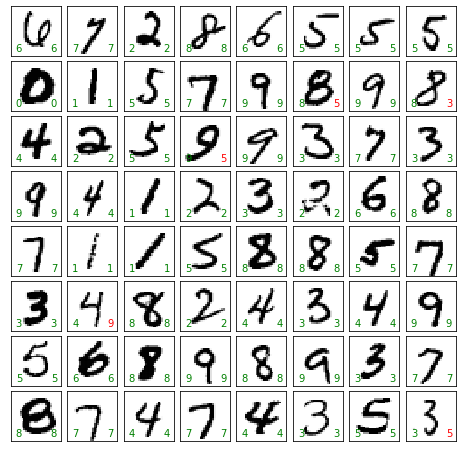

In [15]:
sample_size=batch_size
# let shuffle be True to load random images each time
sample_loader = DataLoader(test_dataset, batch_size=sample_size, shuffle=True) 
data=iter(sample_loader)
samples,sample_labels=next(data)

row_num=8 # if batch_size=64, plot matrix as 8x8
column_num=int(batch_size/row_num)

output = model(samples.view(samples.size(0),-1))
_, pred = torch.max(output, 1)

# print(sample_labels)
# print(pred)

fig, axes = plt.subplots(row_num, column_num, figsize=(8, 8),
                         subplot_kw={'xticks':[], 'yticks':[]},
                         gridspec_kw=dict(hspace=0.1, wspace=0.1))

error = 0 # prediction error
for i, ax in enumerate(axes.flat):
    ax.imshow(samples[i][0], cmap='Greys', interpolation='nearest')
    ax.text(0.1, 0.1, sample_labels[i].numpy(), transform=ax.transAxes, color='green')
    if sample_labels[i].numpy()==pred[i].numpy():
        color_pred='green'
    else:
        color_pred='red'
        error+=1
    ax.text(0.8, 0.1, pred[i].numpy(), transform=ax.transAxes, color=color_pred)

accuracy_predict=(1-error*1.0/sample_size)*100
print(f'Predition Errors: {error} of {sample_size} | Prediction accuracy: {accuracy_predict}%')


<!--
```Python
model.eval()
sample_size=batch_size # take same size sample as batch size
sample_list=np.random.randint(len(test_loader), size=(sample_size))
# print(f'sample list: {sample_list}')

row_num=8 # if batch_size=64, plot matrix as 8x8
column_num=int(sample_size/row_num)

image_list=[test_dataset.data[i] for i in sample_list]
label_list=[test_dataset.targets[i].numpy() for i in sample_list]
image_tensor_list=torch.stack(tmp,0)
image_tensor_list=image_tensor_list.view(ttmp.size(0),-1).float()#reshape and transfer to float data for learning

output = model(image_tensor_list)
_, pred = torch.max(output, 1)

print(label_list)
print(pred)

#---create a grid figure----
fig, axes = plt.subplots(row_num, column_num, figsize=(8, 8),
                         subplot_kw={'xticks':[], 'yticks':[]},
                         gridspec_kw=dict(hspace=0.1, wspace=0.1))

#---iterate and plot figures---
error=0

for i, ax in enumerate(axes.flat):
    image = image_list[i]
    label_original = label_list[i]
    ax.imshow(image, cmap='Greys', interpolation='nearest') # show image
    ax.text(0.1, 0.1, label_original, transform=ax.transAxes, color='green') # show correct label
    # if prediction is correct the color is green; o.w. the predition label is red
    if label_original==pred[i].numpy(): 
        color_pred='green'
    else:
        color_pred='red'
        error+=1
    ax.text(0.8, 0.1, pred[i].numpy(), transform=ax.transAxes, color=color_pred)

accuracy_predict=1-error*1.0/sample_size
print(f'Prediction accuracy: {accuracy_predict}')
```
-->

<font style="font-size:30px" color="red">Your Turn</font>

1. Plot the loss or accuracy with epoch using matplotlib.

1. Try different values for num_epochs.

1. Try different values for batch_size such as 64, 128, 256, 512.

1. Try different learning rate (0.0001, 0.001, 0.1). What is your observation of the evalation loss (`eval_loss`) in training?

1. `relu()` was used as the activation function for the MLP model we implemented. Try other activation functions such as `sigmoid()` and `tanh()`. What is your observation in training? (You may want to refer to the [PyTorch Functional](https://pytorch.org/docs/stable/nn.functional.html) for more details.)
    
1. Try different optimizers such as `SGD` and `Adagrad`.  What is your observation in training? (Refer to [PyTorch Optimizer](https://pytorch.org/docs/stable/optim.html))

1. Try to add/ remove hiden layers, as well as different number of neurons and report your validation results.  What is your observation in training?

1. What can you think of if we want to improve the current model?


<!-- # Assignments: -->


<!-- 1. Can you implment the following functions for model training, evaluation and prediction so we can reuse them when we need to test different things afterwards without having to replicate the codes every time.

```python

def train_model(nn_model, train_loader, optimizer, criterion, n_epoch):
    # YOUR IMPLEMENTATION
    return nn_model

def eval_model(nn_model, val_loader):
    # YOUR IMPLEMENTATION
    return calculated_accuracy


def predict(nn_model, test_loader):
    # YOUR IMPLEMENTATION
    return predictions

```


2. F.sigmoid() was used as the activation function for the MLP model we implemented. Can you try other activation functions such as F.relu() and F.tanh()? You may want to refer to the [PyTorch Functional](https://pytorch.org/docs/stable/nn.functional.html) for more details. Use the train_model(), eval_model() functions you implmented so you don't have to repeat the same codes.

3. Can you add a dropout layer between input and the hidden layer, and another one between the hidden layer and the output layer?

4. Try to add/ remove hiden layers, as well as different number of neurons and report your validation results.

5. Try different learning rate (0.0001, 0.001, 0.01, 0.1). What is your observation?

6. Try different values for batch_size(64, 128, 256, 512).

7. Try different values for n_epochs.

8. What can you think of if we want to improve the current model?
 -->

